# 06 — Protection (REF/ASY + Returnees composition)

**Datasets (source files):**
- `raw_data/hdx_hapi_refugees_afg.csv`
- `raw_data/hdx_hapi_returnees_afg.csv`

**Website section:** `js/sections/protection.js`

This notebook:
1) cleans and aggregates REF/ASY by year (origin AFG),
2) parses Returnees with best-effort column detection,
3) saves cleaned intermediate tables and shows dropped/unusable rows,
4) outputs:
   - `dataset/derived/protection_yearly_totals.csv`
   - `dataset/derived/protection_yearly_shares.csv`


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

RAW_DIR = Path("raw_data")        # raw inputs live here
DATASET_DIR = Path("dataset")     # website reads from here
CLEAN_DIR = DATASET_DIR / "cleaned"
DERIVED_DIR = DATASET_DIR / "derived"

CLEAN_DIR.mkdir(parents=True, exist_ok=True)
DERIVED_DIR.mkdir(parents=True, exist_ok=True)

def to_number(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(",", "").str.strip(), errors="coerce")

def parse_year(val) -> float:
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if len(s) >= 4 and s[:4].isdigit():
        return float(s[:4])
    for sep in ("/", "-"):
        parts = s.split(sep)
        if len(parts) == 3 and parts[-1].isdigit():
            return float(parts[-1])
    return np.nan

def show_filter_report(df_before: pd.DataFrame, mask: pd.Series, title: str, sample_n: int = 10):
    kept = df_before[mask].copy()
    dropped = df_before[~mask].copy()
    print(f"=== {title} ===")
    print("rows_before:", len(df_before))
    print("rows_kept:", len(kept))
    print("rows_dropped:", len(dropped))
    if len(dropped):
        print("\nSample dropped rows:")
        display(dropped.head(sample_n))
    return kept, dropped


In [6]:
ref_raw = pd.read_csv("hdx_hapi_refugees_afg.csv")
ret_raw = pd.read_csv("hdx_hapi_returnees_afg.csv")

ref_raw.head(), ret_raw.head()


(  origin_location_code  origin_has_hrp  origin_in_gho asylum_location_code  \
 0                  AFG            True           True                  AFG   
 1                  AFG            True           True                  AFG   
 2                  AFG            True           True                  AFG   
 3                  AFG            True           True                  AFG   
 4                  AFG            True           True                  AFG   
 
    asylum_has_hrp  asylum_in_gho population_group gender age_range  min_age  \
 0            True           True              OOC      f       0-4      0.0   
 1            True           True              OOC      f      5-11      5.0   
 2            True           True              OOC      f     12-17     12.0   
 3            True           True              OOC      f     18-59     18.0   
 4            True           True              OOC      f       60+     60.0   
 
    max_age  population reference_period_s

In [8]:
# Refugees: keep only REF/ASY records for origin AFG (no destination filter here; same as JS)
ref = ref_raw.copy()
ref["year"] = ref["reference_period_start"].apply(parse_year)
ref["population_num"] = to_number(ref["population"])

mask = (ref["origin_location_code"].astype(str).str.strip() == "AFG") &        (ref["year"].notna()) &        (ref["population_num"].notna()) &        (ref["population_num"] > 0)

if "population_group" in ref.columns:
    g = ref["population_group"].astype(str).str.strip().str.upper()
    mask = mask & (g.isin(["REF","ASY"]))

ref_kept, ref_dropped = show_filter_report(ref, mask, "Protection: refugees filter (origin AFG, year ok, pop>0, group REF/ASY)")
ref_kept["year"] = ref_kept["year"].astype(int)
ref_kept["group"] = ref_kept["population_group"].astype(str).str.strip().str.upper()

ref_clean_out = CLEAN_DIR / "protection_refugees_clean.csv"
ref_kept.to_csv(ref_clean_out, index=False)

ref_drop_out = CLEAN_DIR / "protection_refugees_dropped.csv"
ref_dropped.to_csv(ref_drop_out, index=False)

(ref_clean_out, ref_drop_out)


=== Protection: refugees filter (origin AFG, year ok, pop>0, group REF/ASY) ===
rows_before: 43927
rows_kept: 14602
rows_dropped: 29325

Sample dropped rows:


,origin_location_code,origin_has_hrp,origin_in_gho,asylum_location_code,asylum_has_hrp,asylum_in_gho,population_group,gender,age_range,min_age,max_age,population,reference_period_start,reference_period_end,year,population_num
0,AFG,True,True,AFG,True,True,OOC,f,0-4,0.0,4.0,8751,2020-01-01,2020-12-31,2020.0,8751
1,AFG,True,True,AFG,True,True,OOC,f,5-11,5.0,11.0,8775,2020-01-01,2020-12-31,2020.0,8775
2,AFG,True,True,AFG,True,True,OOC,f,12-17,12.0,17.0,5828,2020-01-01,2020-12-31,2020.0,5828
3,AFG,True,True,AFG,True,True,OOC,f,18-59,18.0,59.0,18958,2020-01-01,2020-12-31,2020.0,18958
4,AFG,True,True,AFG,True,True,OOC,f,60+,60.0,NaN,587,2020-01-01,2020-12-31,2020.0,587
5,AFG,True,True,AFG,True,True,OOC,f,all,NaN,NaN,42899,2020-01-01,2020-12-31,2020.0,42899
6,AFG,True,True,AFG,True,True,OOC,m,0-4,0.0,4.0,8814,2020-01-01,2020-12-31,2020.0,8814
7,AFG,True,True,AFG,True,True,OOC,m,5-11,5.0,11.0,5017,2020-01-01,2020-12-31,2020.0,5017
8,AFG,True,True,AFG,True,True,OOC,m,12-17,12.0,17.0,4785,2020-01-01,2020-12-31,2020.0,4785
9,AFG,True,True,AFG,True,True,OOC,m,18-59,18.0,59.0,19273,2020-01-01,2020-12-31,2020.0,19273


(WindowsPath('dataset/cleaned/protection_refugees_clean.csv'),
 WindowsPath('dataset/cleaned/protection_refugees_dropped.csv'))

In [10]:
# Returnees: best-effort extraction (matches JS philosophy)
ret = ret_raw.copy()

def extract_year(row):
    for col in ["reference_period_start","reference_period","date","period_start","year"]:
        if col in row and pd.notna(row[col]):
            if col == "year" and str(row[col]).strip().isdigit():
                return int(str(row[col]).strip())
            y = parse_year(row[col])
            if y is not None and not np.isnan(y):
                return int(y)
    return None

def extract_value(row):
    for col in ["population","value","count","returnees"]:
        if col in row and pd.notna(row[col]):
            try:
                v = float(str(row[col]).replace(",","").strip())
            except:
                v = None
            if v is not None and np.isfinite(v) and v > 0:
                return v
    return None

years = []
vals = []
ok_mask = []
for _, r in ret.iterrows():
    y = extract_year(r)
    v = extract_value(r)
    ok = (y is not None) and (v is not None)
    ok_mask.append(ok)
    if ok:
        years.append(y)
        vals.append(v)

ok_mask = pd.Series(ok_mask, index=ret.index)
ret_kept, ret_dropped = show_filter_report(ret, ok_mask, "Protection: returnees usable rows (must parse year + positive value)")

ret_df = pd.DataFrame({"year": years, "RET": vals})
ret_agg = ret_df.groupby("year", as_index=False)["RET"].sum()

ret_clean_out = CLEAN_DIR / "protection_returnees_clean.csv"
ret_agg.to_csv(ret_clean_out, index=False)

ret_drop_out = CLEAN_DIR / "protection_returnees_dropped.csv"
ret_dropped.to_csv(ret_drop_out, index=False)

(ret_clean_out, ret_drop_out)


=== Protection: returnees usable rows (must parse year + positive value) ===
rows_before: 559
rows_kept: 448
rows_dropped: 111

Sample dropped rows:


,origin_location_code,origin_has_hrp,origin_in_gho,asylum_location_code,asylum_has_hrp,asylum_in_gho,population_group,gender,age_range,min_age,max_age,population,reference_period_start,reference_period_end
0,AFG,True,True,AFG,True,True,RET,f,0-4,0.0,4.0,0,1/1/2001,12/31/2001
1,AFG,True,True,AFG,True,True,RET,f,11-May,5.0,11.0,0,1/1/2001,12/31/2001
2,AFG,True,True,AFG,True,True,RET,f,17-Dec,12.0,17.0,0,1/1/2001,12/31/2001
3,AFG,True,True,AFG,True,True,RET,f,18-59,18.0,59.0,0,1/1/2001,12/31/2001
4,AFG,True,True,AFG,True,True,RET,f,60+,60.0,NaN,0,1/1/2001,12/31/2001
5,AFG,True,True,AFG,True,True,RET,f,all,NaN,NaN,0,1/1/2001,12/31/2001
6,AFG,True,True,AFG,True,True,RET,m,0-4,0.0,4.0,0,1/1/2001,12/31/2001
7,AFG,True,True,AFG,True,True,RET,m,11-May,5.0,11.0,0,1/1/2001,12/31/2001
8,AFG,True,True,AFG,True,True,RET,m,17-Dec,12.0,17.0,0,1/1/2001,12/31/2001
9,AFG,True,True,AFG,True,True,RET,m,18-59,18.0,59.0,0,1/1/2001,12/31/2001


(WindowsPath('dataset/cleaned/protection_returnees_clean.csv'),
 WindowsPath('dataset/cleaned/protection_returnees_dropped.csv'))

In [12]:
# Combine totals
ref_agg = (ref_kept.pivot_table(index="year", columns="group", values="population_num", aggfunc="sum", fill_value=0)
             .reset_index())
for c in ["REF","ASY"]:
    if c not in ref_agg.columns:
        ref_agg[c] = 0.0

tot = pd.merge(ref_agg, ret_agg, on="year", how="outer").fillna(0)
tot["total"] = tot.get("REF", 0) + tot.get("ASY", 0) + tot.get("RET", 0)
tot = tot[tot["total"] > 0].sort_values("year")

shares = tot.copy()
shares["REF_share"] = shares["REF"] / shares["total"]
shares["ASY_share"] = shares["ASY"] / shares["total"]
shares["RET_share"] = shares["RET"] / shares["total"]
shares = shares[["year","REF_share","ASY_share","RET_share"]]

out_tot = DERIVED_DIR / "protection_yearly_totals.csv"
out_sh = DERIVED_DIR / "protection_yearly_shares.csv"
tot.to_csv(out_tot, index=False)
shares.to_csv(out_sh, index=False)

(out_tot, out_sh)


(WindowsPath('dataset/derived/protection_yearly_totals.csv'),
 WindowsPath('dataset/derived/protection_yearly_shares.csv'))

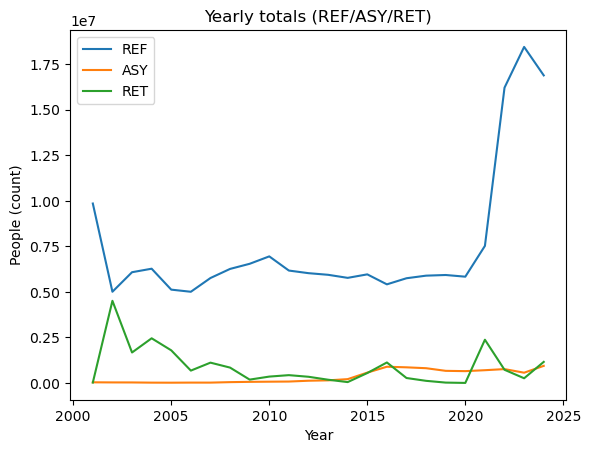

In [14]:
plt.figure()
plt.plot(tot["year"], tot["REF"], label="REF")
plt.plot(tot["year"], tot["ASY"], label="ASY")
plt.plot(tot["year"], tot["RET"], label="RET")
plt.title("Yearly totals (REF/ASY/RET)")
plt.xlabel("Year")
plt.ylabel("People (count)")
plt.legend()
plt.show()
